# Detrend Data<a id='top' class="tocSkip"> </a>

This tutorial shows how to detrend data - a commonly-used technique prior to detailed climate data analysis - using [CDAT](https://cdat.llnl.gov).

[Download the Jupyter Notebook](Detrend_data.ipynb)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Prepare-Notebook-and-Data" data-toc-modified-id="Prepare-Notebook-and-Data-1">Prepare Notebook and Data</a></span><ul class="toc-item"><li><span><a href="#Download-Data" data-toc-modified-id="Download-Data-1.1">Download Data</a></span></li><li><span><a href="#Open-Data-File,-Extract-Variable" data-toc-modified-id="Open-Data-File,-Extract-Variable-1.2">Open Data File, Extract Variable</a></span></li><li><span><a href="#Set-up-for-Demonstrating-That-Order-Matters-If-Missing-Data" data-toc-modified-id="Set-up-for-Demonstrating-That-Order-Matters-If-Missing-Data-1.3">Set-up for Demonstrating That Order Matters If Missing Data</a></span></li></ul></li><li><span><a href="#Removing-the-Annual-Cycle" data-toc-modified-id="Removing-the-Annual-Cycle-2">Removing the Annual Cycle</a></span></li><li><span><a href="#Detrend-Data" data-toc-modified-id="Detrend-Data-3">Detrend Data</a></span></li></ul></div>

## Prepare Notebook and Data
[Back to Top](#top)

In [1]:
from __future__ import print_function
import cdms2
import MV2
import genutil
import cdutil
import vcs
import os
import requests

### Download Data
The following NetCDF file contains Near-Surface Air Temperature data in degrees Kelvin (K) over North America. It is downloaded to the directory where this notebook is stored.

In [2]:
filename = 'tas_Amon_IPSL-CM5A-LR_1pctCO2_r1i1p1_185001-198912.nc'
if not os.path.exists(filename):
    r = requests.get("https://cdat.llnl.gov/cdat/sample_data/notebooks/{}".format(filename), stream=True)
    with open(filename,"wb") as f:
        for chunk in r.iter_content(chunk_size=1024):
            if chunk:  # filter local_filename keep-alive new chunks
                f.write(chunk)

### Open Data File, Extract Variable
The following two lines of code open the file just downloaded to your local computer (`filename`) and extract data for the Near-Surface Air Temperature (`tas`) and assign it to the variable `data`.

In [3]:
f = cdms2.open(filename)

data = f("tas")

In the following line of code, let's take a quick look at the data using the `.info()` method.  Since this file is a subset of the globe, the data cover 13 latitude bands and 16 longitude values. There are 1680 different time values which are measured as "days since 1850-01-01 00:00:00". The range of time values is the difference between the last value (51084.5) and the first value (15.5) which equals 51069 days. If we divide this range by the number of values in the dataset (51069/1680) we get an average time duration for each data point of 30.398 days which tells us that we are working with monthly data.

In [4]:
data.info()

*** Description of Slab tas ***
id: tas
shape: (1680, 13, 16)
filename: 
missing_value: 1e+20
comments: 
grid_name: <None>
grid_type: generic
time_statistic: 
long_name: Near-Surface Air Temperature
units: K
tileIndex: None
original_name: t2m
associated_files: baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation gridspecFile: gridspec_atmos_fx_IPSL-CM5A-LR_1pctCO2_r0i0p0.nc areacella: areacella_fx_IPSL-CM5A-LR_1pctCO2_r0i0p0.nc
coordinates: height
standard_name: air_temperature
cell_methods: time: mean (interval: 30 minutes)
cell_measures: area: areacella
history: 2011-03-07T11:45:34Z altered by CMOR: Treated scalar dimension: 'height'. 2011-03-07T11:45:34Z altered by CMOR: replaced missing value flag (9.96921e+36) with standard missing value (1e+20). 2011-03-07T11:45:34Z altered by CMOR: Inverted axis: lat.
Grid has Python id 0x1118bfc50.
Gridtype: generic
Grid shape: (13, 16)
Order: yx
** Dimension 1 **
   id: time
   Designated a time axis.
   units:  days since 1850-01-01 00:00:0

### Set-up for Demonstrating That Order Matters If Missing Data
To demonstrate `genutil`'s capabilities and highlight that the order of operations matters for data where some values are missing, we'll try two test cases: 
1. removing the annual cycle from the data, then creating a time series and 
2. creating the time series, then removing the annual cycle.

First we need to create a dataset that has missing values, so we'll mask (delete) some data.

We'll delete, or mask, all data values that fall in the range between the maximum temperature of the dataset and 2 degrees less than the maximum temperature - `data.max()-2`. (All temperatures in the dataset are in degrees Kelvin (K).)

In [5]:
data_masked = MV2.masked_greater(data, data.max()-2)

To get a feel for the data, let's create a time series of the raw data that will span the entire 1680 time values in the data file. In creating the time series, the `averager` function will focus on a single time value at a time and take the temperature data for the entire Earth for that time value and do a spatial average to yield a single global temperature value for each time value in the data set.

In [8]:
data_ts = genutil.averager(data, axis='xy')

In the next line of code, let's take a look at the time series. Note the annual cycle and the warming trend over time.

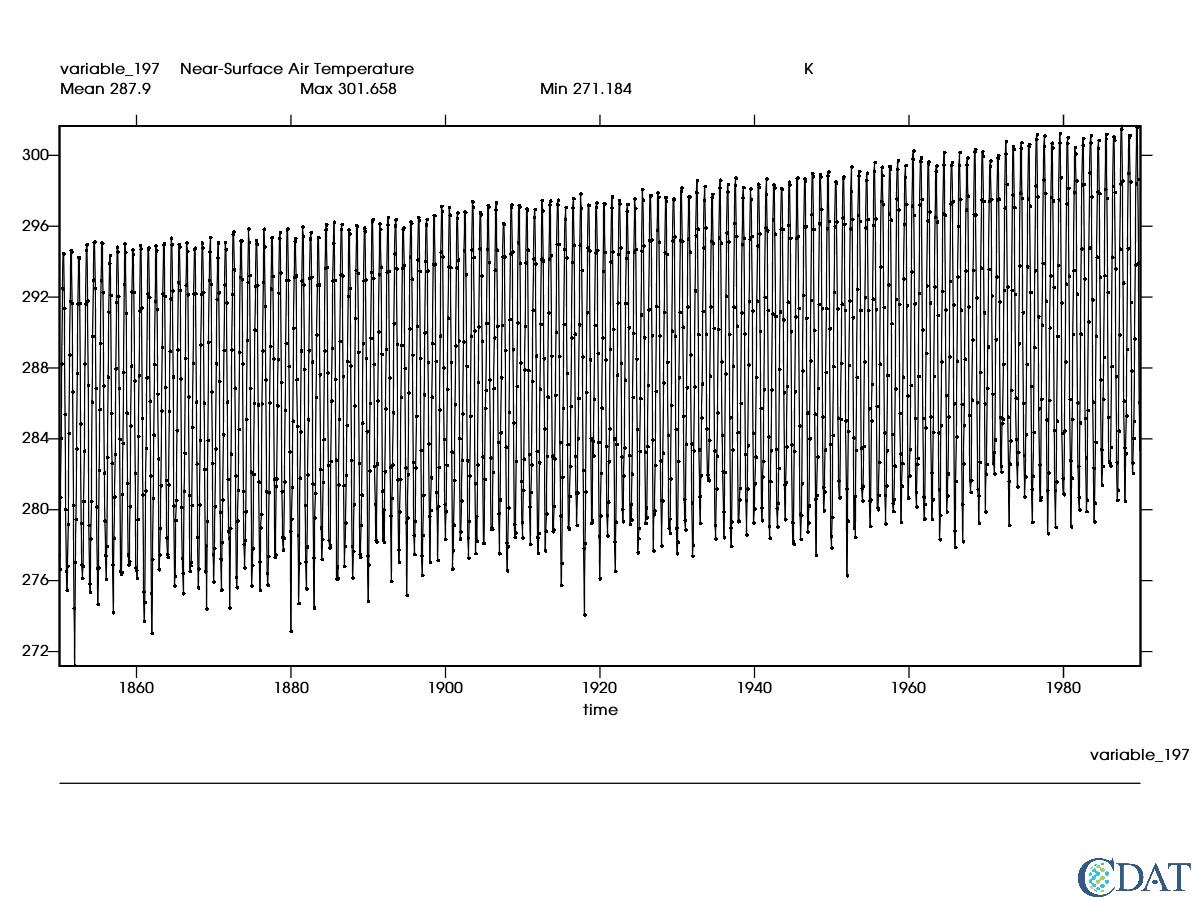

In [20]:
x = vcs.init(bg=True, geometry=(1200,900))
line = vcs.create1d()
line.markersize = .5
x.plot(data_ts, line)

In [6]:
data_masked_ts = genutil.averager(data_masked, axis='xy')

Let's take a look at the time series. Note the trend and the annual cycle.

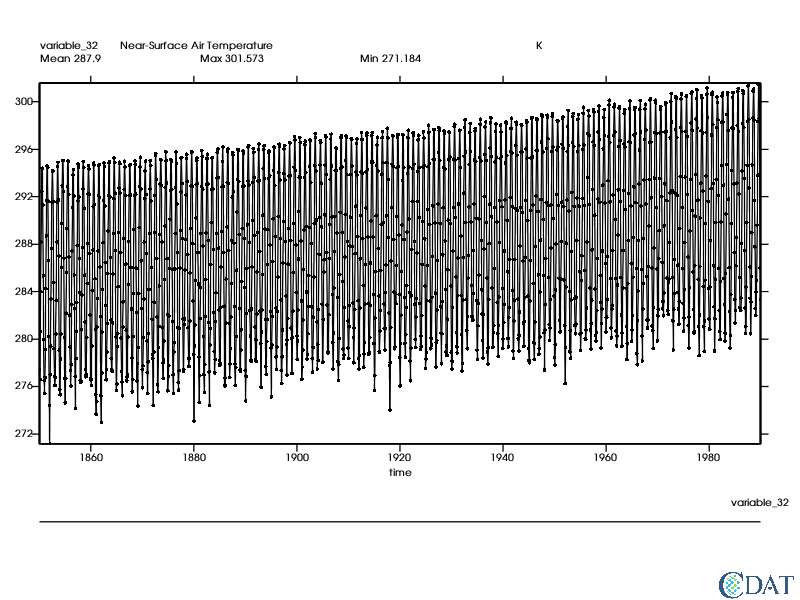

In [7]:
x = vcs.init(bg=True, geometry=(800,600))
line = vcs.create1d()
line.markersize = .5
x.plot(data_masked_ts, line)

## Removing the Annual Cycle 
[Back to Top](#top)

First we will remove the annual cycle for these monthly data. Because the data are masked (i.e. some data are missing) the order of operation matters, as we will demonstrate.

In [ ]:
data_departures = cdutil.times.ANNUALCYCLE.departures(data_masked) # extract the departures of the original data.
data_departures_ts = genutil.averager(data_departures, axis='xy') # create time series of the data departures.
data_ts_departures = cdutil.times.ANNUALCYCLE.departures(data_masked_ts) # extract the departures of the original data_ts time series data.

Notice how the trend shows up much nicer now!

In [ ]:
x.clear()
x.plot(data_departures_ts)

Please note the importance of the order of operation when missing data is present. The two time series are slightly different especially in the later years, where missing data occurs since the temperature crosses the threshold to be removed (2 degrees cooler than the maximum temperature).

In [ ]:
x.clear()
x.plot(data_departures_ts - data_ts_departures)

## Detrend Data
[Back to Top](#top)

First we will compute the trend over `time`. Note that the index of time can be anything; `genutil` will determine its index.

After computation we lose the time axis. Also note the units: since the time axis units are in `days since XXX`, the coeff/trend is in `K/day`.

In [ ]:
coeff, intercept = genutil.statistics.linearregression(data_departures, axis="t")
print("Shapes: coeff {}, intercept {}".format(coeff.shape, intercept.shape))
# Let's do the same for the time series
coeff_ts, intercept_ts = genutil.statistics.linearregression(data_departures_ts, axis="t")

Now let's actually remove the trend.

In [ ]:
times = MV2.array(data_masked.getTime()[:])
times.setAxis(0, data_masked.getTime())

# since time is not necessarily on index 0 we need to use the grower function
# we use data as the first argument to ensure the same order
tmp, full_times = genutil.grower(data_departures, times)
# same for cefficient
tmp, coeff = genutil.grower(data_masked, coeff)
# same for intercept
tmp, intercept = genutil.grower(data_masked, intercept)

data_departures_detrend = data_departures - full_times * coeff - intercept
data_departures_ts_detrend = data_departures_ts - times * coeff_ts - intercept_ts
x.clear()
x.plot(data_departures_ts_detrend)

Here, again, the order matters.

In [ ]:
data_departures_detrend_ts = genutil.averager(data_departures_detrend, axis='xy')

x.clear()
x.plot(data_departures_detrend_ts - data_departures_ts_detrend)

The CDAT software was developed by LLNL. This tutorial was written by Charles Doutriaux with help from Holly Davis. This work was performed under the auspices of the U.S. Department of Energy by Lawrence Livermore National Laboratory under Contract DE-AC52-07NA27344.